## Chapter 3 - Linear Regression

In [80]:
import numpy as np
import pandas as pd 

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

import statsmodels.api as sm
from patsy import dmatrices

In [2]:
file_name = 'Advertising.csv'
df_adv = pd.read_csv(f'data/{file_name}', index_col=0)

In [3]:
df_adv.head(2)

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4


### Simple Linear Regression

In [4]:
def simple_least_squares(x, y):
    """Returns the estimates of intercept and slope for the
    simple linear regression model."""
    beta1 = np.sum((x-np.mean(x))*(y-np.mean(y)))/np.sum(np.power(x-np.mean(x),2))
    beta0 = np.mean(y) - beta1*np.mean(x)
    return beta0, beta1

In [5]:
def get_rss(beta0, beta1, x, y_true):
    """Return the residual sum of squares."""
    y_hat = beta0 + beta1*x
    return np.sum(np.power(y_true-y_hat,2))

In [70]:
coeffs = simple_least_squares(df_adv['TV'],df_adv['sales'])

(-10, 310)

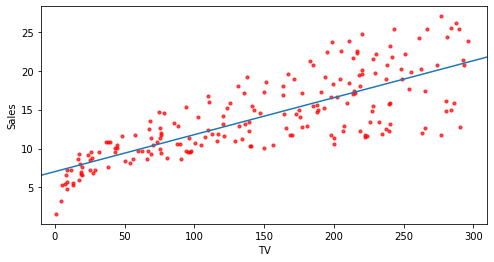

In [7]:
x = np.linspace(-10, 310, 100)
fig = plt.figure(figsize=(8,4))
plt.scatter(df_adv['TV'], df_adv['sales'], marker='o', color='r', alpha=0.7, s = 10)
plt.plot(x, coeffs[0]+x*coeffs[1], linestyle='solid')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.xlim((-10,310))

In [8]:
get_rss(coeffs[0], coeffs[1], df_adv['TV'],df_adv['sales'])

2102.5305831313512

In [9]:
beta0_vec = np.linspace(2, 12, 10)
beta1_vec = np.linspace(0.02, 0.07, 10)
X, Y = np.meshgrid(beta0_vec, beta1_vec, indexing='xy')
Z = np.zeros((beta0_vec.size,beta1_vec.size))
for index, x in np.ndenumerate(Z):
    Z[index] = get_rss(X[index], Y[index], df_adv['TV'], df_adv['sales'])

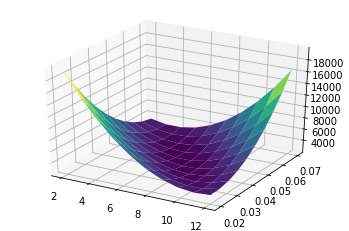

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

#### Testing the bias of least square estimators

Defining population:

In [58]:
def sample(size):
    beta0, beta1 = 2, 3
    mu, sigma = 0, 2
    x = np.linspace(-2, 2, size)
    y = beta0 + beta1*x + np.random.normal(mu, sigma, size)
    return np.column_stack((x,y))

In [59]:
sample0 = sample(50)

In [60]:
coeffs0 = simple_least_squares(sample0[:,0],sample0[:,1])

Text(0, 0.5, 'Y')

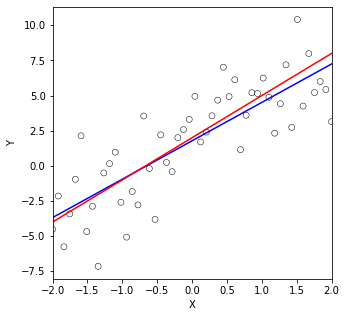

In [62]:
x = np.linspace(-2, 2, 30)
fig = plt.figure(figsize=(5,5))
plt.scatter(sample0[:,0], sample0[:,1], facecolors='none', linewidths=.5, edgecolors='black')
plt.plot(x, coeffs0[0]+x*coeffs0[1], linestyle='solid', c='blue', label='least squares line')
plt.plot(x, 2+x*3, linestyle='solid', c='red', label='population line')
plt.xlim((-2,2))
plt.xlabel('X')
plt.ylabel('Y')

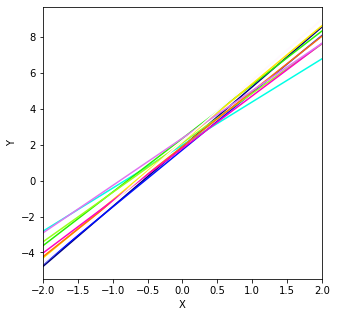

In [68]:
# define np array to gether the coofs -> calculate mean
num_plots = 10
colormap = plt.cm.gist_ncar 
colors = [colormap(i) for i in np.linspace(0, 1, num_plots)]

x = np.linspace(-2, 2, 30)
fig = plt.figure(figsize=(5,5))
plt.xlim((-2,2))
plt.xlabel('X')
plt.ylabel('Y')
for i in range(num_plots):
    samplei = sample(50)
    coeffsi = simple_least_squares(samplei[:,0],samplei[:,1])
    plt.plot(x, coeffsi[0]+x*coeffsi[1], linestyle='solid', c=colors[i])

In [77]:
# simple Monte Carlo simulation
def MonteCarlo(n_simulations):
    beta0_coeffs = []
    beta1_coeffs = []
    
    for i in range(n_simulations):
        samplei = sample(80)
        coeffsi = simple_least_squares(samplei[:,0],samplei[:,1])
        beta0_coeffs.append(coeffsi[0])
        beta1_coeffs.append(coeffsi[1])
        
    return sum(beta0_coeffs)/len(beta0_coeffs), sum(beta1_coeffs)/len(beta1_coeffs)

In [78]:
MonteCarlo(10000)

(1.9997666693431235, 2.9962852334022316)

The mean of 10 000 least square estimates of coefficients is close to the population coefficients - 2 and 3. The least squared produces unbiased estimators. 

### Multiple linear regression

In [82]:
y, X = dmatrices('sales ~ TV + radio + newspaper', data=df_adv, return_type='dataframe')

In [85]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 15 Oct 2020   Prob (F-statistic):           1.58e-96
Time:                        21:01:31   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

**Standard error** - the average amount that the estimator differs from the actual value from the population

**95% Confidence intervals** - estimator +/- 2*SE(estimator). Range of values that contains the true value of coeffictient with 95% probability

**t-statistics** - number of standard deviations the the estimator of coefficient is from zero (if the null hypothesis is beta=0)

**p-value** - the probability that we will t-statistics value to be equal to the value computed or higher, when assuming that null hypothesis holds. If this probability is low (low p-value), we reject the null hypothesis and declare that the relationship between Xj and Y exists.  

In the OLS results summary, we can see that newspaper variable is not statistically significant. What is interesting is the fact that fitting the model with only this predictor leads to other results:

In [88]:
y, X = dmatrices('sales ~ newspaper', data=df_adv, return_type='dataframe')

In [89]:
mod2 = sm.OLS(y, X)
res2 = mod2.fit()
print(res2.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3514      0.621     19.876      0.000      11.126      13.577
newspaper      0.0547      0.017      3.300      0.001       0.022       0.087


The newspaper variable is highly correlated with the other two predictors - TV and radio. 
There is a tendency to spend more on newspaper advertising in markets where more is spent on radio/TV advertising:

In [92]:
df_adv.loc[:, df_adv.columns != 'sales'].corr()

,TV,radio,newspaper
TV,1.000000,0.054809,0.056648
radio,0.054809,1.000000,0.354104
newspaper,0.056648,0.354104,1.000000


According to conducted multiple regression, there is no relationship between newspaper spend and sales, and there is  positive relationship between TV and radio spend and sales. In the markets that spend more on TV/radio, the spend on advertisers also will be higher. 

Therefore, in simple regression higher values of newspaper spend will be associated with higher values of sales, even though such relationship doesn't really exists.

***

**R^2 Statistics** - proportion of variance in reposonse Y explained by the model to total inherent variance of Y. The advantege over RSS is that it is independent of scale of Y (not measured in units of Y), with values typically between 0 and 1 (There is a possibility of negative values of R^2 in case of really poor models)

**F-statistic** - allows to test whether there is a relationship between the response and predictors in multiple regression setting. H0 is that all coefficients are equal 0. H1 is that there is at least one non-zero coefficient.

It is useful in the case of large values of predictors. Example: We assume that number of predictors = 100 and the null hypothesis - H0: beta0 = beta1 = ... = betap = 0 holds (there is no variable that is truly asssociated with the response). In this situation about 5% of predicors will have p-value lower that 0.05 by chance - we will incorrectly conclude that there is relationship. F-statistic doesn't suffer from this problem because it adjusts for the number of predictors - when H0 is true, there is only 5% chance that p-va

testowanie hipotez

TODO:
simple vs multiple regression - w jedym istotny a w drugim nieistotny (na podstawie radio tv data)